# Match Result Estimation


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_folder = './data/'

# WL 2018
#match_name = 'WL2018_ARG_CAN'
#match_name = 'WL2018_ARG_ENG'
#match_name = 'WL2018_ARG_RUS'
#match_name = 'WL2018_ARG_SRB'
#match_name = 'WL2018_ARG_UKR'

# PAN 2018
#match_name = 'PAN2018_ARG_CAN'

# WL 2019
#match_name = 'WL2019_ARG_RUS'
match_name = 'WL2019_ARG_SRB'

The matches are equivalent to rows in a matrix, where first column is ELO of player 1 (team A) and second column is ELO of player 2 (team B)

In [3]:
M = np.array([
    [1450, 1350],
    [1615, 1645],
    [1710, 1705],
    [1900, 1880],
    [1913, 1940],
    [2100, 2180],
    [2102, 2150]
])


An alternative is to specify a deviation for each ELO rating unsig Glicko RD (Rating Deviation). The RD values shall be in columns 3 (team A) and 4 (team B).

In [4]:
M = np.array([
    [1450, 1350, 0, 150],
    [1615, 1645, 0, 150],
    [1710, 1705, 0, 150],
    [1900, 1880, 0, 150],
    [1913, 1940, 0, 150],
    [2100, 2180, 0, 150],
    [2102, 2150, 0, 150]
])


In [5]:
M = np.array([
    [1450, 1350, 15, 35],
    [1615, 1645, 58, 98],
    [1710, 1705, 56, 12],
    [1900, 1880, 167, 88],
    [1913, 1940, 97, 35],
    [2100, 2180, 66, 45],
    [2102, 2150, 36, 88]
])


## Read M from xlsx

In [6]:
import pandas as pd

In [7]:
#M_xlsx = pd.read_excel('WL2019_ARG_RUS.xlsx', index_col=None, header=None)
#M_xlsx = pd.read_excel('WL2019_ARG_SRB.xlsx', index_col=None, header=None)
M_xlsx = pd.read_excel(data_folder+match_name+'.xlsx', index_col=None, header=None)

# print(M_xlsx)

M = M_xlsx.values
#print(M)

## Probabilities functions

In [8]:
def get_draw_rate(R1, R2):
    rd = np.abs(R1 - R2)
    ra = (R1 + R2)/2
    
    dr = -rd/32.49 + np.exp((ra-2254.7)/208.49)+23.87
    return dr/100

In [9]:
def get_result_expectation(R1, R2):
    rd = R1 - R2
    dr = get_draw_rate(R1, R2)
    
    Pw = 1 / (1 + np.power(10, -1*rd/400)) - 0.5*dr
    Pl = 1 / (1 + np.power(10, rd/400)) - 0.5*dr
    Pd = dr
    return Pw, Pl, Pd

## Plotting functions

In [10]:
def plot_match_elos(M):
    
    n = np.arange(1,M.shape[0]+1)
    cmap = plt.get_cmap('Set1')
    cmap_A = cmap(1)
    cmap_B = cmap(2)

    plt.figure(figsize=(15,5))
    
    plt.plot(n, M[:,0], color=cmap_A, label='Team A')
    plt.plot(n, M[:,1], color=cmap_B, label='Team B')
    
    if M.shape[1] > 2:
        plt.fill_between(n, M[:,0] - M[:,2], M[:,0] + M[:,2], color=cmap_A, alpha=0.2)
        plt.fill_between(n, M[:,1] - M[:,3], M[:,1] + M[:,3], color=cmap_B, alpha=0.2)
    
    plt.xlim([1, len(n)])
    plt.xlabel('# board')
    plt.ylabel('ELO')
    plt.title('ELO per board')
    plt.legend()
    plt.savefig('./outputs/'+match_name+'_elos.png')
    plt.show()
    
    return

def plot_match_elo_diff(M):
    n = np.arange(1,M.shape[0]+1)
    cmap = plt.get_cmap('Set1')
    cmap_diff = cmap(3)
    
    diff = M[:,0] - M[:,1]
    
    plt.figure(figsize=(15,5))
    plt.plot(n, diff, color=cmap_diff, label='diff')
    
    if M.shape[1] > 2:
        diff_var = np.sqrt(np.power(M[:,2],2) + np.power(M[:,3],2))
        plt.fill_between(n, diff - diff_var, diff + diff_var, color=cmap_diff, alpha=0.2)
    
    plt.xlim([1, len(n)])
    plt.xlabel('# board')
    plt.ylabel('ELO difference')
    plt.title('ELO difference per board')
    plt.legend()
    plt.savefig('./outputs/'+match_name+'_elo_diff.png')
    plt.show()
    
    return

## Match statistics

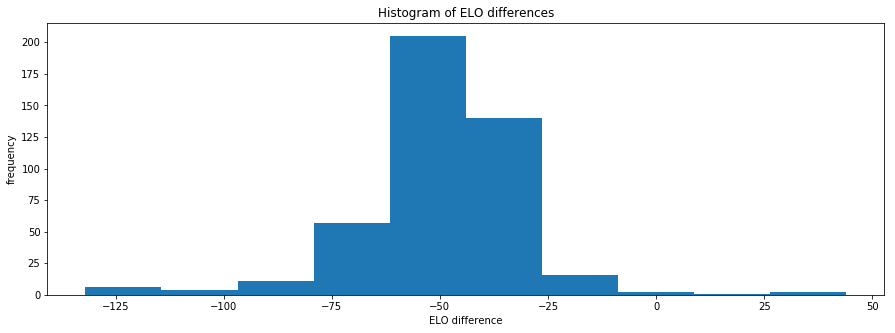

In [11]:
rd_vals = []
for g in M:
    rd_vals.append(g[0]-g[1])

fig = plt.figure(figsize=[15,5])
plt.hist(rd_vals)
plt.title('Histogram of ELO differences')
plt.xlabel('ELO difference')
plt.ylabel('frequency')
plt.savefig('./outputs/'+match_name+'_elo_diff_hist.png')
plt.show()



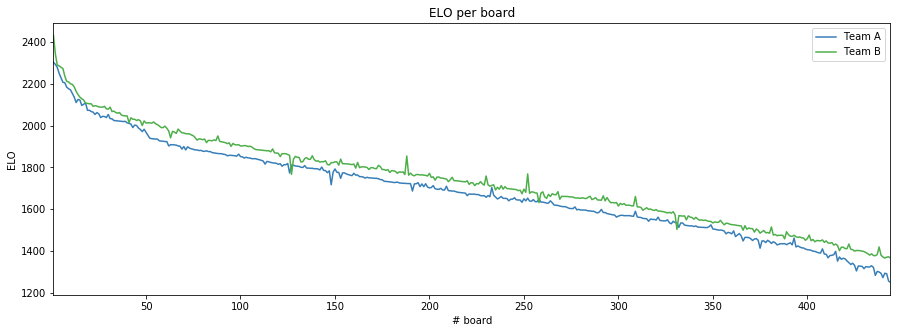

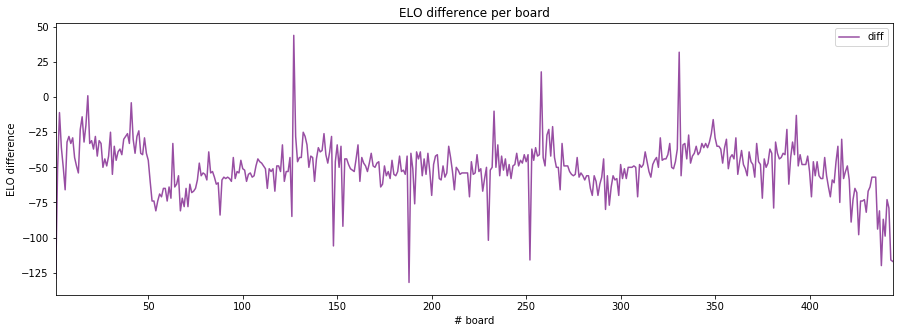

In [12]:
plot_match_elos(M)
plot_match_elo_diff(M)

## Probabilities for each game of the match

In [13]:
P_games = []
for g in M:
    P_games.append(np.asarray(get_result_expectation(g[0], g[1])))

# print(P_games)

## Match simulation

In [14]:
def match_results(M, seed=None, games_per_board=2):
    np.random.seed(seed)
    
    m_trial = np.random.uniform(0.0, 1.0, size=M.shape[0]*games_per_board)
    
    M_results = np.empty([M.shape[0], 2])
    for idx, g in enumerate(M):
        
        ELO_A = g[0]
        ELO_B = g[1]
        
        if len(g) > 2:
            ELO_A = np.random.normal(loc=ELO_A, scale=g[2])
            ELO_B = np.random.normal(loc=ELO_B, scale=g[3])
        
        Pw, Pl, Pd = get_result_expectation(ELO_A, ELO_B)
        
        g_point = 0
        
        for bg in range(games_per_board):
            res = m_trial[idx*games_per_board + bg]

            if res < Pl:
                # lose
                g_point = g_point
            elif res < (Pl + Pd):
                g_point = g_point + 0.5
            else:
                g_point = g_point + 1

        #M_results.append(np.asarray([g_point, games_per_board-g_point]))
        M_results[idx] = np.asarray([g_point, games_per_board-g_point])
        
    return np.asarray(M_results)
    

In [15]:
M_results = match_results(M)

#print(M_results)
print('Final score = {} - {}'.format(np.sum(M_results[:,0]), np.sum(M_results[:,1])))

Final score = 379.5 - 508.5


## N matches simulation

In [16]:
N = 1000

In [17]:
M_scores = np.empty([N,4])

for n in range(N):
    M_results = match_results(M)
    
    A_score = np.sum(M_results[:,0])
    B_score = np.sum(M_results[:,1])
    Dif_score = A_score - B_score
    w_d_l = 1 if Dif_score > 0 else -1 if Dif_score < 0 else 0
    
    
    M_scores[n] = [A_score, B_score, Dif_score, w_d_l]
    
#print(M_scores)

In [18]:
A_score_mean = np.mean(M_scores[:,0])
B_score_mean = np.mean(M_scores[:,1])
A_score_std = np.std(M_scores[:,0])
B_score_std = np.std(M_scores[:,1])

### Plotting results

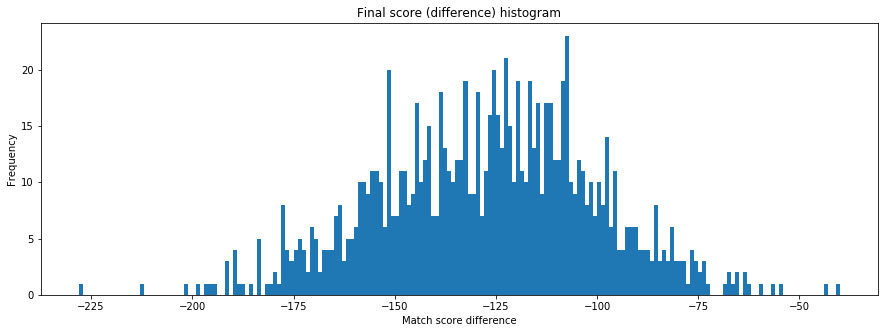

In [19]:
plt.figure(figsize=[15,5])
plt.hist(M_scores[:,2], bins=np.arange(np.min(M_scores[:,2]),np.max(M_scores[:,2])+1), density=False)
plt.title('Final score (difference) histogram')
plt.xlabel('Match score difference')
plt.ylabel('Frequency')
plt.savefig('./outputs/'+match_name+'_final_score_hist.png')
plt.show()

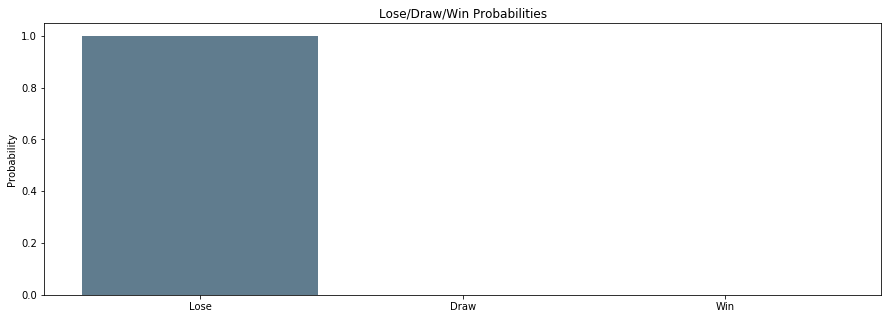

Team A:
	Win chances = 0.00 %
	Draw chances = 0.00 %
	Lose chances = 100.00 %


In [20]:
plt.figure(figsize=[15,5])
p_res, bins, patches = plt.hist(M_scores[:,3], bins=[-1,0,1,2], density=True, rwidth=0.9, color='#607c8e')
plt.title('Lose/Draw/Win Probabilities')
plt.xticks(np.arange(3)-0.5, ('Lose', 'Draw', 'Win',))
plt.ylabel('Probability')
plt.savefig('./outputs/'+match_name+'_LDW_probs.png')
plt.show()
#print(p_res)

print('Team A:')
print('\tWin chances = {:0.2f} %'.format(p_res[2]*100))
print('\tDraw chances = {:0.2f} %'.format(p_res[1]*100))
print('\tLose chances = {:0.2f} %'.format(p_res[0]*100))

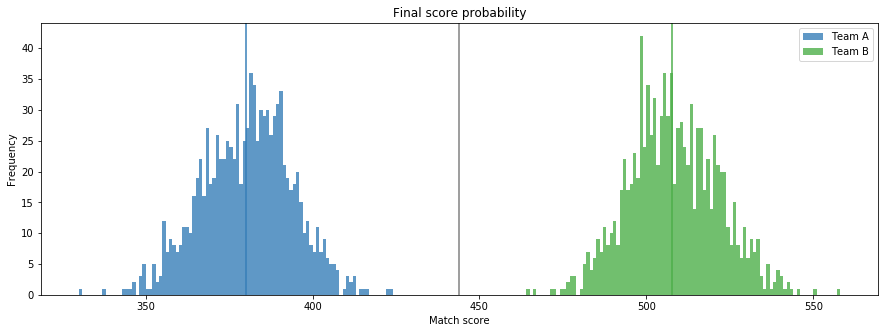

Expected final score = 380.17 (±13.44) - 507.83 (±13.44)


In [21]:
cmap = plt.get_cmap('Set1')
cmap_A = cmap(1)
cmap_B = cmap(2)

plt.figure(figsize=[15,5])
plt.hist(M_scores[:,0], bins=np.arange(np.min(M_scores[:,0]),np.max(M_scores[:,0])+1), 
         density=False, label='Team A', color=cmap_A, alpha=0.8)
plt.hist(M_scores[:,1], bins=np.arange(np.min(M_scores[:,1]),np.max(M_scores[:,1])+1), 
         density=False, label='Team B', color=cmap_B, alpha=0.8)

plt.axvline(x=np.mean(M_scores[:,0]), color=cmap_A)
plt.axvline(x=np.mean(M_scores[:,1]), color=cmap_B)
plt.axvline(x=M.shape[0], color='grey')

plt.legend()
plt.title('Final score probability')
plt.xlabel('Match score')
plt.ylabel('Frequency')
plt.savefig('./outputs/'+match_name+'_final_score_prob.png')
plt.show()

print(r'Expected final score = {:0.2f} (±{:0.2f}) - {:0.2f} (±{:0.2f})'.format(A_score_mean, A_score_std, B_score_mean, B_score_std))